# Snowball Duration with Changing Weatherability

This notebook explores the effect of changing planetary weatherability between and during snowball glaciations on snowball duration.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import ipywidgets as widgets
from ipywidgets import interact
from tqdm.notebook import tqdm

In [2]:
ky2sec = 31540000000
dt = 0.002*ky2sec # in sec
Gy2sec = 3.1557e16
bar2Pa = 100000

S0 = 1365 # solar flux of stable warm state (W/m2)
alpha0 = 0.241 # albedo of stable warm state
alphac = 0.64 # limit of albedo in a cold state
alphaw = 0.2 # limit of albedo in a warm state
T0 = 288  # temperature of stable warm state, (K)
Ti = 273 # transitional temperature at which albedo is halfway between alphac and alphaw (K)

gamma = 5 # temperature scale over which albedo transition operates (K)
P0 = 3e-4 # pCO2 of warm stable state (bars)
C =  2e8 # planetary heat capacity (J/m2/K)
a =  2.2 # slope of T-dependance (W/m2/K)
b =  8 # slope of P-dependance (W/m2)
k =  0.1 # rate constant for dependence of weathering on temperature (1/K)
beta = 0.5 # exponent for dependence of weathering rates on CO2 concentration
Ww = 70/Gy2sec # limit of weathering in a warm state (bars/Gyr) -> bars/sec
W0 = 62.831/Gy2sec # weathering during a warm state, which is equal to volcanic outgassing V (bars/Gyr) -> bars/sec

In [3]:
def albedo(T, alphac=alphac, alphaw=alphaw, Ti=Ti, gamma=gamma):
    """
    compute albedo given temperature
    """
    alpha = alphac - (alphac-alphaw)*(0.5 + np.arctan((T-Ti)/gamma)/np.pi)
    return alpha

def weathering(T, Ww=Ww/Gy2sec, Ti=Ti, gamma=gamma):
    """
    compute weathering given temperature
    """
    W = Ww*(0.5 + np.arctan((T-Ti)/gamma)/np.pi)
    return W

Let's deal with the apparently much shorter duration of the Marinoan snowball. Assuming approximately 5% reduction of solar luminosity per billion years ago in Earth history, let's take solar luminosity around 640 Ma to be 1324 W/m$^2$.

In [4]:
S = 1324
V = 62 # bar/Gyr

In [5]:
def climate(t, z, S, V, Ww, Ti_w, gamma_w, alphac, alphaw, Ti_a, gamma_a):
    T, P = z
    cur_albedo = albedo(T, alphac=alphac, alphaw=alphaw, Ti=Ti_a, gamma=gamma_a)
    RHS_T = 1/C*(S/4*(1-cur_albedo) - S0/4*(1-alpha0) - a*(T-T0) + b*np.log(P/P0))
    cur_weathering = weathering(T, Ww=Ww, Ti=Ti_w, gamma=gamma_w)
    RHS_P = V - cur_weathering*np.exp(k*(T-T0))*(P/P0)**beta
    return [RHS_T, RHS_P]

In [6]:
def transients(t_end, T_ini, P_ini, S, V, 
               Ww, Ti_w, gamma_w, alphac, alphaw, Ti_a, gamma_a):
    """
    t_end : kyr
    """
    V = V/Gy2sec
    # solve equations
    t = np.linspace(0, t_end*ky2sec, 1000)
    sol = solve_ivp(climate, [0, t_end*ky2sec], [T_ini, P_ini], 
                    args=(S, V, Ww, Ti_w, gamma_w, alphac, alphaw, Ti_a, gamma_a),
                    dense_output=True,  method='Radau')
    z = sol.sol(t)

    # return in Myr
    return t/ky2sec/1000, z.T[:, 0]-273.15, z.T[:, 1]*bar2Pa

## Outgassing Variation and Albedo Perturbation

In [7]:
S = 1324

# Vs = np.linspace(180, 
# V1 = 70 # bar/Gyr
Ww = 35
nV = 20
Vs = np.logspace(np.log10(28), np.log10(150), nV)

T_end = 60e3

Ts = []
Ps = []

for ii in range(nV):
    t, cur_T, cur_P = transients(T_end, 230, 0.0003, S, Vs[ii], 
                                 Ww/Gy2sec, Ti, gamma, alphac, alphaw, Ti, gamma)
    Ts.append(cur_T)
    Ps.append(cur_P)

C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:4: RuntimeWarning: invalid value encountered in log
  RHS_T = 1/C*(S/4*(1-cur_albedo) - S0/4*(1-alpha0) - a*(T-T0) + b*np.log(P/P0))
C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:6: RuntimeWarning: invalid value encountered in scalar power
  RHS_P = V - cur_weathering*np.exp(k*(T-T0))*(P/P0)**beta
C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:6: RuntimeWarning: overflow encountered in exp
  RHS_P = V - cur_weathering*np.exp(k*(T-T0))*(P/P0)**beta


albedo

In [8]:
S = 1324
V = 35 # bar/Gyr

T_end = 60e3
t, T1, P1 = transients(T_end, 230, 0.0003, S, V, 
                       V/Gy2sec, Ti, gamma, alphac, alphaw, Ti, gamma)
# t, T2, P2 = transients_3(T_end, 230, 0.0003, S, V, V/Gy2sec)
alphac_2 = 0.59
t, T2, P2 = transients(T_end, 230, 0.0003, S, V, 
                       V/Gy2sec, Ti, gamma, alphac_2, alphaw, Ti, gamma)

C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:4: RuntimeWarning: invalid value encountered in log
  RHS_T = 1/C*(S/4*(1-cur_albedo) - S0/4*(1-alpha0) - a*(T-T0) + b*np.log(P/P0))
C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:6: RuntimeWarning: invalid value encountered in scalar power
  RHS_P = V - cur_weathering*np.exp(k*(T-T0))*(P/P0)**beta
C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:6: RuntimeWarning: overflow encountered in exp
  RHS_P = V - cur_weathering*np.exp(k*(T-T0))*(P/P0)**beta


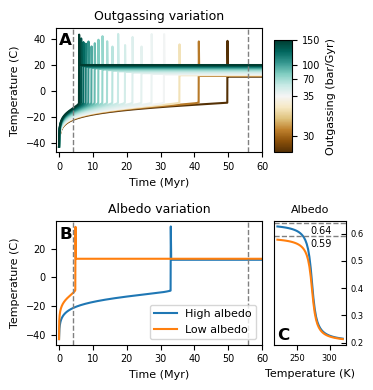

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(4.5, 4), width_ratios=[2, 1])

# outgassing
# colormap
c_norm = colors.TwoSlopeNorm(V, vmin=Vs.min(), vmax=Vs.max())
c_out = plt.get_cmap('BrBG')(c_norm(Vs))
for ii in range(nV):
    ax[0, 0].plot(t, Ts[ii], color=c_out[ii])
ax[0, 0].axvline(56, linestyle='--', color='gray', linewidth=1)
ax[0, 0].axvline(4, linestyle='--', color='gray', linewidth=1)
ax[0, 0].set_xlim([-1, 60])

ax[0, 0].set_xlabel('Time (Myr)', fontsize=8)
ax[0, 0].set_ylabel('Temperature (C)', fontsize=8)
ax[0, 0].set_title('Outgassing variation', fontsize=9)
ax[0, 0].tick_params(labelsize=7)
ax[0, 0].text(0, 35, 'A', fontsize=12, fontweight='bold')

# colorbar
from matplotlib.ticker import LogLocator

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=c_norm,
                                   cmap='BrBG'),
             cax=ax[0, 1], ticks=[30, 35, 70, 100, 150])
cbar.ax.set_ylabel('Outgassing (bar/Gyr)', fontsize=8)
ax[0, 1].tick_params(which='both', labelsize=7)
# ax[0, 1].text(-0.7, 29, 'Seafloor\nweathering', 
#               rotation='vertical', fontsize=7, ha='center')


# albedo variability
ax[1, 0].plot(t, T1, label='High albedo')
ax[1, 0].plot(t, T2, label='Low albedo')
ax[1, 0].axvline(56, linestyle='--', color='gray', linewidth=1)
ax[1, 0].axvline(4, linestyle='--', color='gray', linewidth=1)

ax[1, 0].set_xlabel('Time (Myr)', fontsize=8)
ax[1, 0].set_ylabel('Temperature (C)', fontsize=8)
ax[1, 0].set_title('Albedo variation', fontsize=9)
ax[1, 0].legend(fontsize=8, loc='lower right')
ax[1, 0].tick_params(labelsize=7)
ax[1, 0].set_xlim([-1, 60])
ax[1, 0].text(0, 27, 'B', fontsize=12, fontweight='bold')

T = np.linspace(220, 320)

ax[1, 1].plot(T, albedo(T))
ax[1, 1].plot(T, albedo(T, alphac=alphac_2))
ax[1, 1].axhline(alphac, linestyle='--', color='gray', linewidth=1)
ax[1, 1].text(270, alphac-0.01, f'{alphac}', va='top', fontsize=7)
ax[1, 1].axhline(alphac_2, linestyle='--', color='gray', linewidth=1)
ax[1, 1].text(270, alphac_2-0.01, f'{alphac_2}', va='top', fontsize=7)

ax[1, 1].set_xlabel('Temperature (K)', fontsize=8)
ax[1, 1].set_title('Albedo', fontsize=8)
ax[1, 1].tick_params(labelsize=6)
ax[1, 1].tick_params(axis='y', direction='in')
ax[1, 1].yaxis.tick_right()
ax[1, 1].text(220, 0.21, 'C', fontsize=12, fontweight='bold')

plt.tight_layout()

cbar_ori = ax[0, 1].get_position().get_points()[0].tolist()
cbar_ori[0] = cbar_ori[0] - 0.02
ax[0, 1].set_position(cbar_ori + [0.04, 0.28])

ax11_pos = ax[1, 1].get_position().get_points()
ax11_pos[0:, 0] = ax11_pos[0:, 0] - 0.02
ax11_pos[1, 0] = 0.78
# ax11_pos = np.array([[0.6, 0.], []])
from matplotlib.transforms import Bbox
ax[1, 1].set_position(Bbox.from_extents(ax11_pos))

plt.savefig('figures/outgassing-albedo.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()

## Change in outgassing

## lower (constant) weatherability

Let's first consider the case of lower but constant weatherability.

In [11]:
def weathering_2(T):
    """
    time dependent weathering...
    """
    Ww2 = 65/Gy2sec
    Ti2 = 280
    W = Ww2*(0.5 + np.arctan((T-Ti2)/gamma)/np.pi)
    return W

In [12]:
S = 1324
V = 35 # bar/Gyr

Ww_2 = 25
Ti_2 = 280

T_end = 60e3
t, T1, P1 = transients(T_end, 230, 0.0003, S, V,
                      Ww/Gy2sec, Ti, gamma, alphac, alphaw, Ti, gamma)
t, T2, P2 = transients(T_end, 230, 0.0003, S, V,
                      Ww_2/Gy2sec, Ti_2, gamma, alphac, alphaw, Ti, gamma)

C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:4: RuntimeWarning: invalid value encountered in log
  RHS_T = 1/C*(S/4*(1-cur_albedo) - S0/4*(1-alpha0) - a*(T-T0) + b*np.log(P/P0))
C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:6: RuntimeWarning: invalid value encountered in scalar power
  RHS_P = V - cur_weathering*np.exp(k*(T-T0))*(P/P0)**beta
C:\Users\adrian\AppData\Local\Temp\ipykernel_4880\1421738455.py:6: RuntimeWarning: overflow encountered in exp
  RHS_P = V - cur_weathering*np.exp(k*(T-T0))*(P/P0)**beta


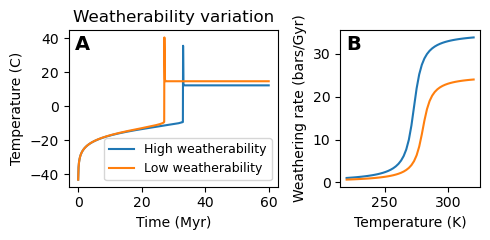

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5), width_ratios=[1.5, 1])

ax[0].plot(t, T1, label='High weatherability')
ax[0].plot(t, T2, label='Low weatherability')

ax[0].set_xlabel('Time (Myr)')
ax[0].set_ylabel('Temperature (C)')
ax[0].set_title('Weatherability variation')
ax[0].legend(fontsize=9, loc='lower right')
ax[0].text(-1, 33, 'A', fontweight='bold', fontsize=14)

T = np.linspace(220, 320)

ax[1].plot(T, weathering(T, Ww=Ww/Gy2sec)*Gy2sec, label='High weatherability')
ax[1].plot(T, weathering(T, Ww=Ww_2/Gy2sec, Ti=Ti_2)*Gy2sec, label='Low weatherability')

ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel('Weathering rate (bars/Gyr)')
ax[1].text(220, 31, 'B', fontweight='bold', fontsize=14)

plt.tight_layout()

plt.savefig('figures/weatherability-variation.pdf', format='pdf', dpi=600, bbox_inches='tight')

plt.show()